In [1]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, load_metric
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0.5, 1.0, '日本語を表示できるかテスト')

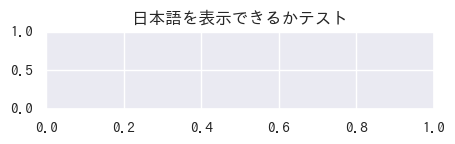

In [2]:
sns.set(font='IPAGothic')

plt.figure(figsize=(5, 1))
plt.title('日本語を表示できるかテスト')

In [3]:
# wrime の読み込み
df_wrime = pd.read_table("/workspace/wrime/wrime-ver1.tsv")
df_wrime.head(2)

# 8感情のリスト
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']
num_labels = len(emotion_names)

df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [4]:
# train / testに分割
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))
print('test :', len(df_test))

train : 17104
test : 1133


In [5]:
# モデル、チェックポイント選択
check_point_num = 4276
model_name = "cl-tohoku/bert-base-japanese-v3"
checkpoint = f"./{model_name}/checkpoint-{check_point_num}/"

# トークナイザ読み込み、モデル指定
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

OSError: cl-tohoku/bert-base-japanese-v3 does not appear to have a file named config.json. Checkout 'https://huggingface.co/cl-tohoku/bert-base-japanese-v3/None' for available files.

In [ ]:
# 前処理・感情強度の正規化(総和=1)
def tokenize_function(batch):
	tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding="max_length")
	tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]
	return tokenized_batch

# transformers用のデータセット形式に変換
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 前処理の適用
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
                                                     

NameError: name 'tokenizer' is not defined